# En<->Fr translation

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.
/home/jhoward/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from gensim.models import word2vec

In [3]:
limit_mem()

In [4]:
path='/data/jhoward/datasets/fr-en-109-corpus/'
dpath = 'data/translate/'

## Prepare corpus

In [5]:
fname=path+'giga-fren.release2.fixed'
en_fname = fname+'.en'
fr_fname = fname+'.fr'

In [6]:
re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')

In [7]:
lines = ((re_eq.search(eq), re_fq.search(fq)) 
         for eq, fq in zip(open(en_fname), open(fr_fname)))

In [8]:
qs = [(e.group(), f.group()) for e,f in lines if e and f]
len(qs)

KeyboardInterrupt: 

In [10]:
qs[:6]

[('What is light ?', 'Qu’est-ce que la lumière?'),
 ('Who are we?', 'Où sommes-nous?'),
 ('Where did we come from?', "D'où venons-nous?"),
 ('What would we do without it?', 'Que ferions-nous sans elle ?'),
 ('What is the absolute location (latitude and longitude) of Badger, Newfoundland and Labrador?',
  'Quelle sont les coordonnées (latitude et longitude) de Badger, à Terre-Neuve-etLabrador?'),
 ('What is the major aboriginal group on Vancouver Island?',
  'Quel est le groupe autochtone principal sur l’île de Vancouver?')]

In [69]:
dump(qs, dpath+'qs.pkl')

In [9]:
qs = load(dpath+'qs.pkl')

In [11]:
en_qs, fr_qs = zip(*qs)

In [12]:
re_mult_space = re.compile(r"  *")
re_mw_punc = re.compile(r"(\w[’'])(\w)")
re_punc = re.compile("([\"().,;:/_?!—])")
re_apos = re.compile(r"(\w)'s\b")

In [13]:
def simple_toks(sent):
    sent = re_apos.sub(r"\1 's", sent)
    sent = re_mw_punc.sub(r"\1 \2", sent)
    sent = re_punc.sub(r" \1 ", sent).replace('-', ' ')
    sent = re_mult_space.sub(' ', sent)
    return sent.lower().split()

In [14]:
fr_qtoks = list(map(simple_toks, fr_qs)); fr_qtoks[:4]

[['qu’', 'est', 'ce', 'que', 'la', 'lumière', '?'],
 ['où', 'sommes', 'nous', '?'],
 ["d'", 'où', 'venons', 'nous', '?'],
 ['que', 'ferions', 'nous', 'sans', 'elle', '?']]

In [15]:
en_qtoks = list(map(simple_toks, en_qs)); en_qtoks[:4]

[['what', 'is', 'light', '?'],
 ['who', 'are', 'we', '?'],
 ['where', 'did', 'we', 'come', 'from', '?'],
 ['what', 'would', 'we', 'do', 'without', 'it', '?']]

In [16]:
simple_toks("Rachel's baby is cuter than other's.")

['rachel', "'s", 'baby', 'is', 'cuter', 'than', 'other', "'s", '.']

In [17]:
def toks2ids(sents):
    voc_cnt = collections.Counter(t for sent in sents for t in sent)
    vocab = sorted(voc_cnt, key=voc_cnt.get, reverse=True)
    vocab.insert(0, "<PAD>")
    w2id = {w:i for i,w in enumerate(vocab)}
    ids = [[w2id[t] for t in sent] for sent in sents]
    return ids, vocab, w2id, voc_cnt

In [18]:
fr_ids, fr_vocab, fr_w2id, fr_counts = toks2ids(fr_qtoks)
en_ids, en_vocab, en_w2id, en_counts = toks2ids(en_qtoks)
len(en_vocab), len(fr_vocab)

(19548, 26708)

## Word vectors

In [16]:
en_vecs, en_wv_word, en_wv_idx = load_glove(
    '/data/jhoward/datasets/nlp/glove/results/6B.100d')

In [17]:
en_w2v = {w: en_vecs[en_wv_idx[w]] for w in en_wv_word}

In [18]:
n_en_vec, dim_en_vec = en_vecs.shape
dim_fr_vec = 200

In [19]:
fr_wik = pickle.load(open('/data/jhoward/datasets/nlp/polyglot-fr.pkl', 'rb'), 
                     encoding='latin1')

- Word vectors: http://fauconnier.github.io/index.html#wordembeddingmodels
- Corpus: https://www.sketchengine.co.uk/frwac-corpus/

In [20]:
w2v_path='/data/jhoward/datasets/nlp/frWac_non_lem_no_postag_no_phrase_200_skip_cut100.bin'
fr_model = word2vec.KeyedVectors.load_word2vec_format(w2v_path, binary=True)
fr_voc = fr_model.vocab

In [21]:
def create_emb(w2v, targ_vocab, dim_vec):
    vocab_size = len(targ_vocab)
    emb = np.zeros((vocab_size, dim_vec))

    for i, word in enumerate(targ_vocab):
        try:
            emb[i] = w2v[word]
        except KeyError:
            # If we can't find the word, randomly initialize
            emb[i] = normal(scale=0.6, size=(dim_vec,))

    return emb

In [22]:
en_embs = create_emb(en_w2v, en_vocab, dim_en_vec); en_embs.shape

(19548, 100)

In [23]:
fr_embs = create_emb(fr_model, fr_vocab, dim_fr_vec); fr_embs.shape

(26708, 200)

## Prep data

In [24]:
en_lengths = collections.Counter(len(s) for s in en_ids)

In [25]:
maxlen = 30

In [26]:
len(list(filter(lambda x: len(x) > maxlen, en_ids))), len(
    list(filter(lambda x: len(x) <= maxlen, en_ids)))

(1726, 50605)

In [27]:
len(list(filter(lambda x: len(x) > maxlen, fr_ids))), len(
    list(filter(lambda x: len(x) <= maxlen, fr_ids)))

(3579, 48752)

In [28]:
en_padded = pad_sequences(en_ids, maxlen, padding="post", truncating="post")

In [29]:
fr_padded = pad_sequences(fr_ids, maxlen, padding="post", truncating="post")

In [30]:
en_padded.shape, fr_padded.shape, en_embs.shape

((52331, 30), (52331, 30), (19548, 100))

In [31]:
n = int(len(en_ids)*0.9)
idxs = np.random.permutation(len(en_ids))
fr_train, fr_test = fr_padded[idxs][:n], fr_padded[idxs][n:]
en_train, en_test = en_padded[idxs][:n], en_padded[idxs][n:]

## Model

In [32]:
en_train.shape

(47097, 30)

In [33]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback()]}

In [249]:
fr_wgts = [fr_embs.T, np.zeros((len(fr_vocab,)))]

In [250]:
inp = Input((maxlen,))
x = Embedding(len(en_vocab), dim_en_vec, input_length=maxlen,
              weights=[en_embs], trainable=False)(inp)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = LSTM(128, return_sequences=True)(x)
x = TimeDistributed(Dense(dim_fr_vec))(x)
x = TimeDistributed(Dense(len(fr_vocab), weights=fr_wgts))(x)
x = Activation('softmax')(x)

In [251]:
model = Model(inp, x)
model.compile('adam', 'sparse_categorical_crossentropy')

In [253]:
K.set_value(model.optimizer.lr, 1e-3)

In [255]:
hist=model.fit(en_train, np.expand_dims(fr_train,-1), batch_size=64, nb_epoch=20, **parms, 
               validation_data=[en_test, np.expand_dims(fr_test,-1)])

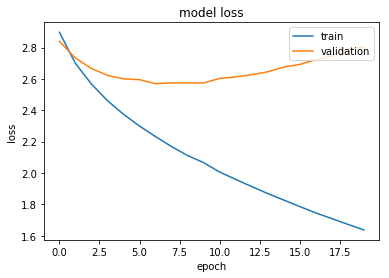

In [264]:
plot_train(hist)

In [154]:
model.save_weights(dpath+'trans.h5')

In [157]:
model.load_weights(dpath+'trans.h5')

## Testing

In [205]:
def sent2ids(sent):
    sent = simple_toks(sent)
    ids = [en_w2id[t] for t in sent]
    return pad_sequences([ids], maxlen, padding="post", truncating="post")

In [208]:
def en2fr(sent): 
    ids = sent2ids(sent)
    tr_ids = np.argmax(model.predict(ids), axis=-1)
    return ' '.join(fr_vocab[i] for i in tr_ids[0] if i>0)

In [212]:
en2fr("what is the size of canada?")

'quelle est le nombre du canada ?'